## Imports, Constants, and Misc Functions

In [1]:

!pip install tabulate

import glob, os, pprint, re, sys, tabulate

from math import log
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [16]:
# Constants / Settings

CATALOGUE_DIR = "../fond-benchmarks"


RESULTS_DIR = "../RESULTS-general"
PLANNERS = ['pr2', 'prp', 'fondsat', 'paladinus',  'mynd']


PLANNER_US = 'PR2'


# RESULTS_DIR = "../RESULTS-ablation"
# PLANNERS = [
#     'pr2',
#     'pr2-no-objsampling',
#     'pr2-no-poisoning',
#     'pr2-no-fsap-penalty',
#     'pr2-no-full-scd-marking',
#     'pr2-no-force-1safe'
# ]


TIME_LIMIT = 3600

cataloguef = os.path.abspath(CATALOGUE_DIR)
sys.path.append(cataloguef)
import catalogue
DOMAINS = catalogue.DOMAINS
COLLECTIONS = catalogue.COLLECTIONS



In [3]:
# Methods to fetch and filter files / content

def results_for_planner(planner):
    if planner == '':
        return glob.glob(f'{RESULTS_DIR}/*')
    else:
        return glob.glob(f'{RESULTS_DIR}/{planner}.*')

def filter_for_domain(results, domain):
    return [res for res in results if f'.{domain}__' in res]

def extract_instance(res_file):
    return res_file.split('.')[-2]

def extract_planner(res_file):
    return res_file.split('/')[-1].split('.')[-3]

def file_contains(fn, target):
    with open(fn, 'r') as f:
        content = f.read()
    return target in content


## Data Extraction

In [4]:

# Methods to extract data

NO_SOL = {
    'solved': False,
    'time': None,
    'search-time': None,
    'size': None
}

def process_pr2(res):
    if not file_contains(res, 'Strong cyclic solution found.'):
        # print(f"PR2 Failed: {res}")
        return NO_SOL
    with open(res, 'r') as f:
        contents = f.read()
    return {
        'solved': True,
        'time': sum([60 * int(m) + float(s) for m, s in re.findall("user\t(\d+)m(\d+.\d+)s", contents)]),
        'search-time': float(re.search(r'Time taken: (\d+.\d+) sec', contents).group(1)),
        'size': int(re.search(r'Solution Size: (\d+)', contents).group(1))
    }

def process_prp(res):
    if not file_contains(res, 'Strong cyclic plan found.'):
        return NO_SOL
    with open(res, 'r') as f:
        contents = f.read()
    return {
        'solved': True,
        'time': sum([60 * int(m) + float(s) for m, s in re.findall("user\t(\d+)m(\d+.\d+)s", contents)]),
        'search-time': float(re.search(r'Total time: (\d+\.?\d*)s', contents).group(1)),
        'size': int(re.search(r'State-Action Pairs: (\d+)', contents).group(1))
    }

def process_fondsat(res):
    # print(res)
    with open(res, 'r') as f:
        contents = f.read()
    if (not (re.search(r'\nSATISFIABLE', contents) or re.search(r'\ns SATISFIABLE', contents))) or (not re.search(r'Elapsed total time', contents)):
        return NO_SOL
    return {
        'solved': True,
        'time': sum([60 * int(m) + float(s) for m, s in re.findall("user\t(\d+)m(\d+.\d+)s", contents)]),
        'search-time': float(re.search(r'Elapsed total time \(s\): (\d+\.?\d*)', contents).group(1)),
        'size': int(re.findall('Trying with (\d+) states', contents)[-1])
    }

def process_paladinus(res):
    if not file_contains(res, 'Result: Policy successfully found.'):
        return NO_SOL
    with open(res, 'r') as f:
        contents = f.read()
    return {
        'solved': True,
        'time': sum([60 * int(m) + float(s) for m, s in re.findall("user\t(\d+)m(\d+.\d+)s", contents)]),
        'search-time': float(re.search(r'Time needed for search:                             (\d+.\d+) seconds.', contents).group(1)),
        'size': int(re.search(r'# Policy Size               = (\d+)', contents).group(1))
    }

def process_mynd(res):
    if not file_contains(res, 'Result: Strong cyclic plan found.') or \
            file_contains(res, '# There is insufficient memory for the Java Runtime Environment to continue.'):
        return NO_SOL
    with open(res, 'r') as f:
        contents = f.read()
    if not re.search(r'Policy entries: (\d+)', contents):
        print(res)
    return {
        'solved': True,
        'time': sum([60 * int(m) + float(s) for m, s in re.findall("user\t(\d+)m(\d+.\d+)s", contents)]),
        'search-time': float(re.search(r'Time needed for search:                             (\d+.\d+) seconds.', contents).group(1)),
        'size': int(re.search(r'Policy entries: (\d+)', contents).group(1))
    }

planner_funcs = {
    'pr2': process_pr2,
    'paladinus': process_paladinus,
    'mynd': process_mynd,
    'fondsat': process_fondsat,
    'prp': process_prp
}

for p in PLANNERS:
    if 'pr2-' == p[:4]:
        planner_funcs[p] = process_pr2

def generate_prob_mapping(all_result_files):
    prob_mapping = {}
    
    # Fetch all the data per problem
    for res in all_result_files:
        domprob = extract_instance(res)
        dom = domprob.split('_')[0]
        prob = domprob.split('_')[-1]
        planner = extract_planner(res)
        if domprob not in prob_mapping:
            prob_mapping[domprob] = {}
        prob_mapping[domprob][planner] = planner_funcs[planner](res)
        prob_mapping[domprob][planner]['domain'] = dom
        prob_mapping[domprob][planner]['problem'] = prob
        prob_mapping[domprob][planner]['planner'] = planner
    return prob_mapping

def missed_solves(prob_mapping):
    data = [PLANNERS]
    for domprob in prob_mapping:
        if not prob_mapping[domprob]['pr2']['solved'] and any([prob_mapping[domprob][planner]['solved'] for planner in PLANNERS if planner != 'pr2']):
            data.append([domprob] + [prob_mapping[domprob][planner]['solved'] for planner in PLANNERS])
    print(tabulate.tabulate(data, headers='firstrow', tablefmt='fancy_grid'))

## Plotting

In [5]:
# Plot stuff
def plot_settings():
    sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
    plt.rc('axes', titlesize=18)     # fontsize of the axes title
    plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
    plt.rc('legend', fontsize=13)    # legend fontsize
    plt.rc('font', size=13)          # controls default text sizes
    sns.color_palette('deep')

def resultfiles_to_df(results = None):
    if results is None:
        results = results_for_planner('')
    
    prob_mapping = generate_prob_mapping(results)
    alldata = []
    for domprob in prob_mapping:
        dom = domprob.split('_')[0]
        prob = domprob.split('_')[-1]
        data = {'domain': dom, 'problem': prob}
        for planner in prob_mapping[domprob]:
            data.update({f"{planner}:{k}": prob_mapping[domprob][planner][k] for k in prob_mapping[domprob][planner] if k not in ['domain', 'problem', 'planner']})
        alldata.append(data)
        
    df = pd.DataFrame(alldata)
    
    return df

def plot_comparison_data(data, reference_planner, stat, xlabel, ylabel, logaxis=False, fname=None):
    MAXTIME = TIME_LIMIT * 2

    # Compute the maximum of all sizes found
    MAXSIZE = max([float(data[f"{planner}:size"].max()) for planner in PLANNERS]) * 2

    # If the planner didn't solve, set the time to the max time and size to the max size
    for planner in PLANNERS:
        data.loc[data[f'{planner}:time'].isna(), f'{planner}:time'] = MAXTIME
        data.loc[data[f'{planner}:size'].isna(), f'{planner}:size'] = MAXSIZE
    
    plot_settings()
    
    plt.figure(figsize=(7,5), tight_layout=True)

    if logaxis:
        plt.yscale('log')
        plt.xscale('log')
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Unique symbol for each planner
    planner2symbol = {
        'pr2': 's',
        'paladinus': 'o',
        'mynd': 'v',
        'fondsat': 'x',
        'prp': 'd',
        'pr2-no-objsampling': 'o',
        'pr2-no-poisoning': 'v',
        'pr2-no-fsap-penalty': 'x',
        'pr2-no-full-scd-marking': 'd',
        'pr2-no-force-1safe': '.',
    }

    for planner in PLANNERS:
        if planner == reference_planner:
            continue
        # plt.plot(data[f"{planner}:{stat}"], data[f"{reference_planner}:{stat}"], 'o', label=planner)
        ax = sns.scatterplot(data=data, x=f"{planner}:{stat}", y=f"{reference_planner}:{stat}", label=planner, marker=planner2symbol[planner])
    
    # Draw an x=y line and set the axis limits
    if stat == 'time':
        MAX = MAXTIME*1.3
    else:
        MAX = MAXSIZE
    plt.plot([0, MAX], [0, MAX], ls='--', c='black')

    if logaxis:
        if stat == 'time':
            MIN = 0.03
        else:
            MIN = 0.5
        plt.xlim(MIN, MAX)
        plt.ylim(MIN, MAX)
    else:
        plt.xlim(0, MAX)
        plt.ylim(0, MAX)
    
    # plt.set(xlabel=xlabel, ylabel=ylabel)
    if fname:
        plt.savefig(fname, dpi=300, format='png')
    plt.show()

def plot_coverage_over_time(coverage_data, xlog=False, fname=None):
    
    plot_settings()
    
    fig = plt.figure(figsize=(8, 5))
    ax = plt.axes()
    if xlog:
        plt.xscale("log")
    # plt.title("Coverage Over Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Coverage")

    # ax = sns.lineplot(data=coverage_data['pr2'], linewidth=2.5)

    for planner in PLANNERS:
        data = coverage_data[planner]
        plt.plot([t[0] for t in data], [t[1] for t in data], linewidth=2.5, label=planner.replace('pr2',PLANNER_US.lower()))

    # ax.set(xlabel='Time (s)', ylabel='Coverage', title='Coverage Over Time')

    ax.legend()#title='Planners', title_fontsize = 13)
    if fname:
        plt.savefig(fname, dpi=300, format='png')
    plt.show()

## Analysis Functions

### Coverage

In [6]:
# Methods for coverage analysis

def coverage(res, normalize=True):
    count = len([r for r in res if r['solved']])
    if normalize:
        return count / len(res)
    else:
        return count

def gen_cov_over_time(planner, normalize=False):
    all_res = results_for_planner(planner)
    data = []
    for dom in COLLECTIONS['all-fond-papers']:
        dom_res = filter_for_domain(all_res, dom)
        if normalize:
            denom = float(len(dom_res))
        else:
            denom = 1.0
        for prob in dom_res:
            res = planner_funcs[planner](prob)
            if res['solved']:
                data.append((res['time'], 1.0 / denom))
    
    total = 0.0
    new_data = []
    for (t, c) in sorted(data):
        total += c
        new_data.append((t, total))
    return new_data

def gen_all_coverage_data(normalize=True):
    coverage_data = {}
    for planner in PLANNERS:
        coverage_data[planner] = gen_cov_over_time(planner, normalize=normalize)
    return coverage_data



### Time

In [7]:
# Methods for time analysis

def generate_time_scores(all_result_files):
    
    prob_mapping = generate_prob_mapping(all_result_files)

    # Compute the normalized time scores according to IPC (https://ipc2023-classical.github.io/)
    for prob in prob_mapping:
        for planner in prob_mapping[prob]:
            t = prob_mapping[prob][planner]['time']
            if not prob_mapping[prob][planner]['solved']:
                prob_mapping[prob][planner]['score-time'] = 0.0
            elif t <= 1.0:
                prob_mapping[prob][planner]['score-time'] = 1.0
            else:
                prob_mapping[prob][planner]['score-time'] = 1.0 - (log(t) / log(TIME_LIMIT))
    return prob_mapping
        

## Exploration

In [8]:
missed_solves(generate_prob_mapping(results_for_planner('')))

╒══════════════════════╤═══════╤═══════════╤═════════════╤════════╤═══════╕
│                      │ prp   │ fondsat   │ paladinus   │ mynd   │ pr2   │
╞══════════════════════╪═══════╪═══════════╪═════════════╪════════╪═══════╡
│ forest-new__p_10_1   │ True  │ False     │ False       │ False  │ False │
├──────────────────────┼───────┼───────────┼─────────────┼────────┼───────┤
│ forest-new__p_10_7   │ True  │ False     │ False       │ False  │ False │
├──────────────────────┼───────┼───────────┼─────────────┼────────┼───────┤
│ forest-new__p_10_10  │ True  │ False     │ False       │ False  │ False │
├──────────────────────┼───────┼───────────┼─────────────┼────────┼───────┤
│ forest-new__p_10_2   │ True  │ False     │ False       │ False  │ False │
├──────────────────────┼───────┼───────────┼─────────────┼────────┼───────┤
│ blocksworld-new__p42 │ True  │ False     │ False       │ False  │ False │
╘══════════════════════╧═══════╧═══════════╧═════════════╧════════╧═══════╛


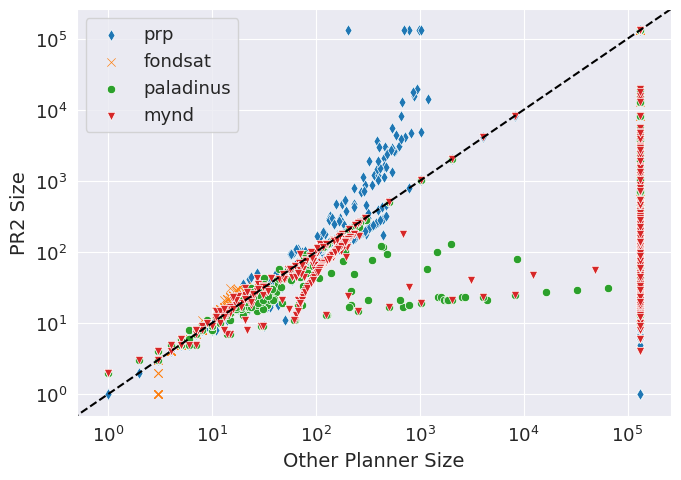

In [9]:
df = resultfiles_to_df()

plot_comparison_data(df, 'pr2', 'time', xlabel='Other Planner Time (s)', ylabel=f'{PLANNER_US} Time (s)', logaxis=True, fname='timeplot.png')
plot_comparison_data(df, 'pr2', 'size', xlabel='Other Planner Size', ylabel=f'{PLANNER_US} Size', logaxis=True, fname='sizeplot.png')

In [10]:
all_res_files = results_for_planner('')
prob_mapping = generate_time_scores(all_res_files)


data = [['domain (size)'] + PLANNERS]
totals = [0.0] * len(PLANNERS)
prob_count = 0
for dom in COLLECTIONS['all-fond-papers']:
    
    res = filter_for_domain(all_res_files, dom)
    prob_mapping = generate_time_scores(res)
    domtotals = {p: 0.0 for p in PLANNERS}
    for prob in prob_mapping:
        for planner in prob_mapping[prob]:
            domtotals[planner] += prob_mapping[prob][planner]['score-time']
            
    scores = []
    for planner in PLANNERS:
        scores.append(domtotals[planner])
    for i in range(len(totals)):
        totals[i] += scores[i]
    data.append([f'{dom} ({len(DOMAINS[dom])})']+scores)
    prob_count += len(DOMAINS[dom])
data.append([f'TOTAL ({prob_count})'] + totals)

print(tabulate.tabulate(data, headers='firstrow', tablefmt='fancy_grid'))


╒═══════════════════════════╤═══════════╤════════════╤═════════════╤═══════════╤═══════════╕
│ domain (size)             │       prp │    fondsat │   paladinus │      mynd │       pr2 │
╞═══════════════════════════╪═══════════╪════════════╪═════════════╪═══════════╪═══════════╡
│ acrobatics (8)            │   6.85419 │   2.84813  │     7.53348 │   7.73613 │   7.77338 │
├───────────────────────────┼───────────┼────────────┼─────────────┼───────────┼───────────┤
│ beam-walk (11)            │   9.81086 │   2.03556  │     8.52759 │   9.09975 │  10.0212  │
├───────────────────────────┼───────────┼────────────┼─────────────┼───────────┼───────────┤
│ blocksworld-new (50)      │  28.9054  │   4.78315  │    13.3332  │  12.3834  │  27.7679  │
├───────────────────────────┼───────────┼────────────┼─────────────┼───────────┼───────────┤
│ chain-of-rooms (10)       │   9.86721 │   0.303707 │     9.49117 │   7.58277 │  10       │
├───────────────────────────┼───────────┼────────────┼─────────────┼──

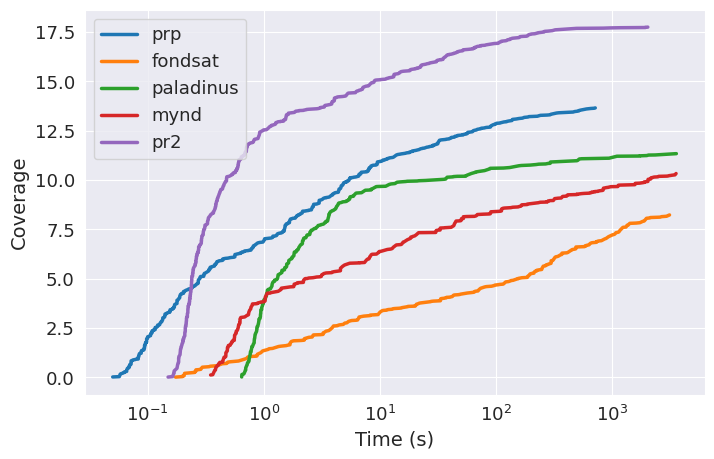

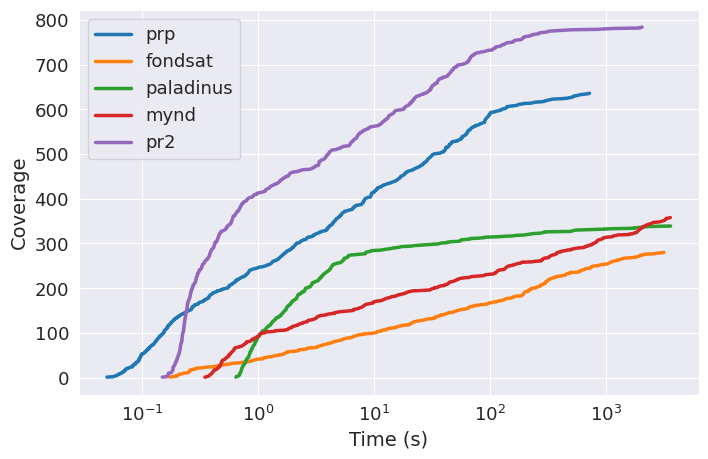

In [11]:
norm_data = gen_all_coverage_data(normalize=True)
unnorm_data = gen_all_coverage_data(normalize=False)

plot_coverage_over_time(norm_data, xlog=True, fname='coverageovertime.png')
plot_coverage_over_time(unnorm_data, xlog=True)

In [12]:
print(COLLECTIONS['all-fond-papers'])

['acrobatics', 'beam-walk', 'blocksworld-new', 'chain-of-rooms', 'earth-observation', 'elevators', 'faults-new', 'first-responders-new', 'forest-new', 'tidyup-mdp', 'tireworld', 'triangle-tireworld', 'zenotravel', 'doors', 'islands', 'miner', 'tireworld-spiky', 'tireworld-truck']


In [49]:
# Coverage table

longnames = ['tireworld', 'triangle-tireworld', 'zenotravel', 'doors', 'islands', 'miner', 'tireworld-spiky', 'tireworld-truck']

domain_translation = {d:d for d in COLLECTIONS['all-fond-papers']}
domain_translation['blocksworld-new'] = 'bw-new'
domain_translation['chain-of-rooms'] = 'chain'
domain_translation['earth-observation'] = 'earth-obs'
domain_translation['first-responders-new'] = 'first-new'
domain_translation['tireworld'] = 'tire'
domain_translation['triangle-tireworld'] = 'tri-tire'
domain_translation['zenotravel'] = 'zeno'
domain_translation['tireworld-spiky'] = 'tire-spiky'
domain_translation['tireworld-truck'] = 'tire-truck'


data = [['domain (size)'] + PLANNERS]
totals = [0.0] * len(PLANNERS)
prob_count = 0
for dom in COLLECTIONS['all-fond-papers']:
    cov = []
    for planner in PLANNERS:
        res = results_for_planner(planner)
        res = filter_for_domain(res, dom)
        res = [planner_funcs[planner](r) for r in res]
        cov.append(coverage(res, normalize=True))
    for i in range(len(totals)):
        totals[i] += cov[i]
    data.append([f'{domain_translation[dom]} ({len(DOMAINS[dom])})']+cov)
    prob_count += len(DOMAINS[dom])
data.append([f'TOTAL ({prob_count})'] + totals)



print(tabulate.tabulate(data, headers='firstrow', tablefmt='fancy_grid'))


╒══════════════════╤═══════════╤════════════╤═══════════╤═════════════╤════════════╕
│ domain (size)    │       pr2 │        prp │   fondsat │   paladinus │       mynd │
╞══════════════════╪═══════════╪════════════╪═══════════╪═════════════╪════════════╡
│ acrobatics (8)   │  1        │  1         │ 0.5       │   1         │  1         │
├──────────────────┼───────────┼────────────┼───────────┼─────────────┼────────────┤
│ beam-walk (11)   │  1        │  1         │ 0.272727  │   0.818182  │  1         │
├──────────────────┼───────────┼────────────┼───────────┼─────────────┼────────────┤
│ bw-new (50)      │  0.82     │  0.84      │ 0.16      │   0.36      │  0.42      │
├──────────────────┼───────────┼────────────┼───────────┼─────────────┼────────────┤
│ chain (10)       │  1        │  1         │ 0.1       │   1         │  1         │
├──────────────────┼───────────┼────────────┼───────────┼─────────────┼────────────┤
│ earth-obs (40)   │  1        │  1         │ 0.175     │   0.65 

In [50]:
assert data[0][1] == 'pr2' or 'pr2' not in data[0]
data[0][1] = 'pr2'

for row in range(1,len(data)):
    best = max(data[row][1:])
    for col in range(1, len(data[row])):
        if data[row][col] == best:
            data[row][col] = '\\textbf{' + f'{data[row][col]:.2f}' + '}'
        else:
            data[row][col] = f'{data[row][col]:.2f}'

table_str = tabulate.tabulate(data, headers='firstrow', tablefmt='latex', floatfmt=".2f")
print(table_str)

\begin{tabular}{llllll}
\hline
 domain (size)    & pr2            & prp           & fondsat       & paladinus     & mynd          \\
\hline
 acrobatics (8)   & \textbackslash{}textbf\{1.00\}  & \textbackslash{}textbf\{1.00\} & 0.50          & \textbackslash{}textbf\{1.00\} & \textbackslash{}textbf\{1.00\} \\
 beam-walk (11)   & \textbackslash{}textbf\{1.00\}  & \textbackslash{}textbf\{1.00\} & 0.27          & 0.82          & \textbackslash{}textbf\{1.00\} \\
 bw-new (50)      & 0.82           & \textbackslash{}textbf\{0.84\} & 0.16          & 0.36          & 0.42          \\
 chain (10)       & \textbackslash{}textbf\{1.00\}  & \textbackslash{}textbf\{1.00\} & 0.10          & \textbackslash{}textbf\{1.00\} & \textbackslash{}textbf\{1.00\} \\
 earth-obs (40)   & \textbackslash{}textbf\{1.00\}  & \textbackslash{}textbf\{1.00\} & 0.17          & 0.65          & 0.78          \\
 elevators (15)   & \textbackslash{}textbf\{1.00\}  & \textbackslash{}textbf\{1.00\} & 0.47          & 0.53     